In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import numpy as np 
import pandas as pd 
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import datetime
import time
import sys
PATH_DATASET = '../Dataset/'
PATH_RESULTS = '../Results/'

In [2]:
df_item = pd.read_csv(os.path.join(PATH_DATASET,'meta-item.csv'))
df_item.head(2)

,I100,I101,I102,I103
0,0,2,1,1
1,1,2,1,1


In [3]:
df_store = pd.read_csv(os.path.join(PATH_DATASET,'meta-store.csv'))
df_store.head(2)

,S100,S101,S102,S103
0,0,1,17,10
1,1,1,18,10


In [4]:
df_sales = pd.read_csv(os.path.join(PATH_DATASET,'sales.csv'))
print(df_sales.columns)
df_sales.head(2)

Index(['DATE', 'S100', 'I100', 'C100', 'C101', 'QTT'], dtype='object')


,DATE,S100,I100,C100,C101,QTT
0,2017-01-08,0,0,12,76,2
1,2017-01-08,0,0,12,149,3


In [5]:
df_sales['DATE'].unique()

array(['2017-01-08', '2017-01-15', '2017-01-22', '2017-01-29',
       '2017-02-05', '2017-02-12', '2017-02-19', '2017-02-26',
       '2017-03-05', '2017-03-12', '2017-03-19', '2017-03-26',
       '2017-04-02', '2017-04-09', '2017-04-16', '2017-04-23',
       '2017-04-30', '2017-05-07', '2017-05-14', '2017-05-21',
       '2017-05-28', '2017-06-04', '2017-06-11', '2017-06-18',
       '2017-06-25', '2017-07-02', '2017-07-09', '2017-07-16',
       '2017-07-23', '2017-07-30', '2017-08-06', '2017-08-13',
       '2017-08-20', '2017-08-27', '2017-09-03', '2017-09-10',
       '2017-09-17', '2017-09-24', '2017-10-01', '2017-10-08',
       '2017-10-15', '2017-10-22', '2017-10-29', '2017-11-05',
       '2017-11-12', '2017-11-19', '2017-11-26', '2017-12-03',
       '2017-12-10', '2017-12-17', '2017-12-24', '2017-12-31',
       '2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
       '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
       '2018-03-04', '2018-03-11', '2018-03-18', '2018-

In [6]:
df_submission_sample = pd.read_csv(os.path.join(PATH_DATASET,'submission_sample.csv'))
df_submission_sample.head(2)

,ID,QTT
0,2021-10-03_0_1_12_140,-1
1,2021-10-03_0_1_12_164,-1


In [7]:
df_submission_sample[['DATE', 'S100', 'I100', 'C100', 'C101']] = df_submission_sample['ID'].str.split('_',expand=True)


In [8]:
df_submission_sample.head(2)

,ID,QTT,DATE,S100,I100,C100,C101
0,2021-10-03_0_1_12_140,-1,2021-10-03,0,1,12,140
1,2021-10-03_0_1_12_164,-1,2021-10-03,0,1,12,164


In [9]:
df_submission_sample['DATE'].unique()

array(['2021-10-03', '2021-10-10', '2021-10-17', '2021-10-24',
       '2021-10-31', '2021-11-07', '2021-11-14', '2021-11-21'],
      dtype=object)

In [10]:
def preprocess(df):
    
    df[['year', 'month', 'day']] = df['DATE'].str.split('-',expand=True)
    
    
    for value in [ 'S100', 'I100', 'C100', 'C101','month', 'year', 'day']:        
        df[value] = df[value].astype(str).astype(int)
    
    df = df.merge(df_item,on=['I100'])
    df = df.merge(df_store,on=['S100'])
    

    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df['day_of_week'] = df['DATE'].dt.day_of_week
    df['day_of_year'] = df['DATE'].dt.day_of_year
    
    df['is_year_start']    = df['DATE'].dt.is_year_start
    df['is_quarter_start'] = df['DATE'].dt.is_quarter_start
    df['is_month_start']   = df['DATE'].dt.is_month_start
    df['is_month_end']    = df['DATE'].dt.is_month_end
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')    
    
    

    return df

In [11]:
df_sales = preprocess(df_sales)
df_submission_sample = preprocess(df_submission_sample)

In [12]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,year,month,day,I101,...,I103,S101,S102,S103,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end
0,2017-01-08,0,0,12,76,2,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
1,2017-01-08,0,0,12,149,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
2,2017-01-08,0,0,12,256,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
3,2017-01-08,0,0,12,354,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
4,2017-01-08,0,0,13,149,2,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False


In [13]:
df_sales.head(2)

,DATE,S100,I100,C100,C101,QTT,year,month,day,I101,...,I103,S101,S102,S103,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end
0,2017-01-08,0,0,12,76,2,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
1,2017-01-08,0,0,12,149,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False


In [14]:
df_sales[df_sales['DATE']=='2017-01-08'].head()

,DATE,S100,I100,C100,C101,QTT,year,month,day,I101,...,I103,S101,S102,S103,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end
0,2017-01-08,0,0,12,76,2,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
1,2017-01-08,0,0,12,149,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
2,2017-01-08,0,0,12,256,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
3,2017-01-08,0,0,12,354,3,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False
4,2017-01-08,0,0,13,149,2,2017,1,8,2,...,1,1,17,10,6,8,False,False,False,False


In [15]:
df_sales.year.value_counts()

2018    692537
2017    673045
2019    649977
2020    385544
2021    348266
Name: year, dtype: int64

In [16]:
df_submission_sample.year.value_counts()

2021    69121
Name: year, dtype: int64

In [17]:
df_submission_sample.head(2)

,ID,QTT,DATE,S100,I100,C100,C101,year,month,day,...,I103,S101,S102,S103,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end
0,2021-10-03_0_1_12_140,-1,2021-10-03,0,1,12,140,2021,10,3,...,1,1,17,10,6,276,False,False,False,False
1,2021-10-03_0_1_12_164,-1,2021-10-03,0,1,12,164,2021,10,3,...,1,1,17,10,6,276,False,False,False,False


In [18]:
df_sales.columns

Index(['DATE', 'S100', 'I100', 'C100', 'C101', 'QTT', 'year', 'month', 'day',
       'I101', 'I102', 'I103', 'S101', 'S102', 'S103', 'day_of_week',
       'day_of_year', 'is_year_start', 'is_quarter_start', 'is_month_start',
       'is_month_end'],
      dtype='object')

In [19]:
features_names = ['S100', 'I100', 'C100', 'C101', 'month', 'year', 'day','I101', 'I102', 'I103', 'S101', 'S102', 'S103']
X_train = df_sales[features_names].copy()
y_train = df_sales['QTT']

X_submission = df_submission_sample[features_names].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print('X_train      :',X_train.shape)
print('X_validation :',X_validation.shape)
print('X_test       :',X_test.shape)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict

In [ ]:
import lightgbm as lgb


In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    #'objective': 'regression',
   #'objective': 'tweedie',
   #'tweedie_variance_power': 1.1,
    'metric': ['l1','l2'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 8000
}

In [ ]:


hyper_params ={      
   'device' : 'cpu',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.01,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_validation, y_validation)],
        eval_metric='rmse',
        early_stopping_rounds=100)

In [ ]:
X_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm.predict(X_validation, num_iteration=gbm.best_iteration_)
X_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

X_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_error

df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)

In [ ]:
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

In [ ]:
df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions','submission_data_eginerring_'+str(df_test_rmse)+'_local.csv'),index=None)

In [ ]:
save = False
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)


In [20]:
year = 2019
window = 2

def get_features(year,window):
    df_before = df_sales[['DATE','I101','I102','I103','S101','S102','S103','S100','I100','C100','C101']][(df_sales['DATE'] > str(year-window)+'-01-01') & (df_sales['DATE'] < str(year)+'-01-01')]

    f_agg = {}

    for value in ['I101','I102','I103','S101','S102','S103']:
        f_agg[value] = ['mean', 'min', 'max']

    original_columns = ['S100','I100','C100','C101']
    result = df_before.groupby(original_columns).agg(f_agg)
    result = result.reset_index()

    #result.columns = result.columns.droplevel(0)
    result.columns = ["_".join(x) if x[0] not in original_columns else x[0] for x in result.columns.ravel() ]

    result['year'] = year
    return result


In [21]:
df_features_2019 = get_features(2019,2)
df_features_2020 = get_features(2020,2)
df_features_2021 = get_features(2021,2)

/tmp/ipykernel_3199/1449275936.py:17: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  result.columns = ["_".join(x) if x[0] not in original_columns else x[0] for x in result.columns.ravel() ]


In [22]:
df_submission_sample_save = df_submission_sample.copy()

In [ ]:
df_submission_sample = df_submission_sample_save.copy()

df_2019 = df_sales[(df_sales['DATE'] >= '2019-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2020 = df_sales[(df_sales['DATE'] >= '2020-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2021 = df_sales[(df_sales['DATE'] >= '2021-01-01') & (df_sales['DATE'] < '2022-01-01')].copy()

df_2019 = df_2019.merge(df_features_2019,on=['S100','I100','C100','C101','year'], how='left')
df_2020 = df_2020.merge(df_features_2020,on=['S100','I100','C100','C101','year'], how='left')
df_2021  =df_2021.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')

df_submission_sample  = df_submission_sample.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')


df_sales2 = pd.concat([df_2019,df_2020,df_2021])
df_sales2.head()

df_sales2.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)
#features_names = set(list(df_sales2.columns))- set(['DATE','QTT'])
features_names = set(df_sales2.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num']) 
X_train = df_sales2[features_names].copy()
y_train = df_sales2['QTT']

X_submission = df_submission_sample[features_names].copy()

In [ ]:
print(features_names)

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    #'objective': 'regression',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 8000
}

In [ ]:
hyper_params={      
   'device' : 'cpu',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.1,

    #'num_leaves': 200, #110 #100 #150 large, but over-fitting
    #'max_depth': 10, # deal with over-fitting
    #'min_data_in_leaf': 30, # deal with over-fitting
    
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 8
   }    

In [ ]:
model_version = 'c_model_v4_lessdata'

nfolds = 5

nrepeats = 2 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
    
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
print(folds)

fold_pred_fi = np.zeros(len(X_train))


feature_importance_df_fi = pd.DataFrame()
predictions_submission_fi = pd.DataFrame()

lgb_preds_fi = np.zeros(len(X_submission))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
#for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred_fi[val_idx] = X_validation_pred
    
    fold_importance_df_fi = pd.DataFrame()
    fold_importance_df_fi["feature"] = X_train.columns
    fold_importance_df_fi["importance"] = lgb_model.feature_importance()
    fold_importance_df_fi["fold"] = fold_ + 1
    feature_importance_df_fi = pd.concat([feature_importance_df_fi, fold_importance_df_fi], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    lgb_preds_fi += X_submission_pred / (nfolds*nrepeats)
    #lgb_preds_fi += X_submission_pred / (nfolds)
    
    predictions_submission_fi[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

In [ ]:
cv_score = np.sqrt(mean_squared_error(fold_pred_fi, y_train))
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

In [ ]:
# predicted value distribution
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds_fi, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
final_importance_fi

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance_fi)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'lgbm_importances.png'))

df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission_fi.mean(axis=1)
df_submission_sample.head()

save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)


In [ ]:
# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
important_features = list(final_importance_fi[0:15]['feature'])
important_features[0:15]

In [30]:
important_features = set(['I100',
 'C101',
 'day_of_year',
 'S100',
 'day',
 'C100',
 'S102_min',
 'month',
 'S103_mean',
 'S102',
 'year',
 'S103',
 'I101',
 'I102_mean',
 'I102'])| set(['S100','I100','C100','C101','year'])
print(important_features)

{'I102', 'I102_mean', 'year', 'S102', 'S102_min', 'S103', 'C101', 'C100', 'S100', 'month', 'S103_mean', 'I100', 'day', 'day_of_year', 'I101'}


In [31]:
features_names = important_features


df_submission_sample = df_submission_sample_save.copy()

df_2019 = df_sales[(df_sales['DATE'] >= '2019-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2020 = df_sales[(df_sales['DATE'] >= '2020-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
df_2021 = df_sales[(df_sales['DATE'] >= '2021-01-01') & (df_sales['DATE'] < '2022-01-01')].copy()

df_2019 = df_2019.merge(df_features_2019,on=['S100','I100','C100','C101','year'], how='left')
df_2020 = df_2020.merge(df_features_2020,on=['S100','I100','C100','C101','year'], how='left')
df_2021  =df_2021.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')

df_submission_sample  = df_submission_sample.merge(df_features_2021,on=['S100','I100','C100','C101','year'], how='left')


df_sales2 = pd.concat([df_2019,df_2020,df_2021])
df_sales2.head()

df_sales2.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)
#features_names = set(list(df_sales2.columns))- set(['DATE','QTT'])
#features_names = set(df_sales2.columns)-set(['QTT','DATE','item_id','ID', 'date_block_num']) 

X_train = df_sales2[features_names].copy()
y_train = df_sales2['QTT']
X_train = X_train[features_names]


X_submission = df_submission_sample[features_names].copy()


#y_validation = X_validation['QTT']
#X_validation = X_validation[features_names]

#y_test = X_test['QTT']
#X_test = X_test[features_names]

y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]


In [32]:
X_submission.head()

,I102,I102_mean,year,S102,S102_min,S103,C101,C100,S100,month,S103_mean,I100,day,day_of_year,I101
0,1,1.0,2021,17,17.0,10,140,12,0,10,10.0,1,3,276,2
1,1,1.0,2021,17,17.0,10,164,12,0,10,10.0,1,3,276,2
2,1,1.0,2021,17,17.0,10,339,12,0,10,10.0,1,3,276,2
3,1,1.0,2021,17,17.0,10,128,13,0,10,10.0,1,3,276,2
4,1,1.0,2021,17,17.0,10,164,14,0,10,10.0,1,3,276,2


In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    #'objective': 'regression',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 8000
}

In [34]:
model_version = 'c_model_v5_fe'

nfolds = 5

nrepeats = 2 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=nfolds, random_state=11, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
    
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
print(folds)

fold_pred_fi = np.zeros(len(X_train))


feature_importance_df_fi = pd.DataFrame()
predictions_submission_fi = pd.DataFrame()

lgb_preds_fi = np.zeros(len(X_submission))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_train.values,y_train.values)):
#for fold_, (trn_idx, val_idx) in enumerate(skf.split(y_train.values,y_train.values)):
    
    print(20*'*'," fold n°{}".format(fold_))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx]) #categorical_feature=categorical_feats

    print('Training ...')
    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 100)
    
    print('make predictions...')
    X_train_pred      = lgb_model.predict(X_train.iloc[trn_idx], num_iteration=lgb_model.best_iteration)
    X_validation_pred = lgb_model.predict(X_train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    #X_test_pred       = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    #X_test_pred = np.maximum(X_test_pred, 0)

    

    df_train_rmse = mean_squared_error(y_train.iloc[trn_idx],X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_train.iloc[val_idx],X_validation_pred, squared=False)
    #df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    #print('Score test :',df_test_rmse)


    fold_pred_fi[val_idx] = X_validation_pred
    
    fold_importance_df_fi = pd.DataFrame()
    fold_importance_df_fi["feature"] = X_train.columns
    fold_importance_df_fi["importance"] = lgb_model.feature_importance()
    fold_importance_df_fi["fold"] = fold_ + 1
    feature_importance_df_fi = pd.concat([feature_importance_df_fi, fold_importance_df_fi], axis=0)
    
    
    
    print('Predict submission ')
    X_submission_pred = lgb_model.predict(X_submission.values, num_iteration=lgb_model.best_iteration)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    lgb_preds_fi += X_submission_pred / (nfolds*nrepeats)
    #lgb_preds_fi += X_submission_pred / (nfolds)
    
    predictions_submission_fi[str(fold_ + 1)] = X_submission_pred
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_fold_'+str(fold_ + 1)+'.txt')
    print('saving model..',model_name)
    lgb_model.save_model(model_name, num_iteration=lgb_model.best_iteration)
    
    #############################

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
RepeatedKFold(n_repeats=2, n_splits=5, random_state=11)
********************  fold n°0
Training ...


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052552 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.14898	valid_1's rmse: 2.27108
[100]	training's rmse: 2.05578	valid_1's rmse: 2.19454
[150]	training's rmse: 2.00101	valid_1's rmse: 2.15382
[200]	training's rmse: 1.96992	valid_1's rmse: 2.13859
[250]	training's rmse: 1.94248	valid_1's rmse: 2.12095
[300]	training's rmse: 1.9198	valid_1's rmse: 2.11342
[350]	training's rmse: 1.89838	valid_1's rmse: 2.10186
[400]	training's rmse: 1.88067	valid_1's rmse: 2.09435
[450]	training's rmse: 1.86646	valid_1's rmse: 2.08904
[500]	training's rmse: 1.85093	valid_1's rmse: 2.08178
[550]	training's rmse: 1.83792	valid_1's rmse: 2.07648
[600]	training's rmse: 1.82729	valid_1's rmse: 2.07311
[650]	training's rmse: 1.81529	valid_1's rmse: 2.06899
[700]	training's rmse: 1.80328	valid_1's rmse: 2.06517
[750]

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.18039	valid_1's rmse: 2.18259
[100]	training's rmse: 2.07312	valid_1's rmse: 2.10262
[150]	training's rmse: 2.02349	valid_1's rmse: 2.06899
[200]	training's rmse: 1.98556	valid_1's rmse: 2.04714
[250]	training's rmse: 1.95707	valid_1's rmse: 2.03233
[300]	training's rmse: 1.93186	valid_1's rmse: 2.02159
[350]	training's rmse: 1.90854	valid_1's rmse: 2.01535
[400]	training's rmse: 1.88934	valid_1's rmse: 2.00982
[450]	training's rmse: 1.8708	valid_1's rmse: 2.00345
[500]	training's rmse: 1.85743	valid_1's rmse: 2.0007
[550]	training's rmse: 1.84396	valid_1's rmse: 1.99711
[600]	training's rmse: 1.83258	valid_1's rmse: 1.99466
[650]	training's rmse: 1.81982	valid_1's rmse: 1.993

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.16909	valid_1's rmse: 2.18855
[100]	training's rmse: 2.06079	valid_1's rmse: 2.11512
[150]	training's rmse: 2.01307	valid_1's rmse: 2.09069
[200]	training's rmse: 1.96941	valid_1's rmse: 2.06892
[250]	training's rmse: 1.94323	valid_1's rmse: 2.05671
[300]	training's rmse: 1.92169	valid_1's rmse: 2.05033
[350]	training's rmse: 1.89938	valid_1's rmse: 2.0423
[400]	training's rmse: 1.88041	valid_1's rmse: 2.03291
[450]	training's rmse: 1.86503	valid_1's rmse: 2.02845
[500]	training's rmse: 1.85155	valid_1's rmse: 2.02438
[550]	training's rmse: 1.84035	valid_1's rmse: 2.02021
[600]	training's rmse: 1.82516	valid_1's rmse: 2.02166
[650]	training's rmse: 1.81284	valid_1's rmse: 2.01

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.16538	valid_1's rmse: 2.21738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 2.06985	valid_1's rmse: 2.14521
[150]	training's rmse: 2.01253	valid_1's rmse: 2.11413
[200]	training's rmse: 1.97789	valid_1's rmse: 2.09324
[250]	training's rmse: 1.94826	valid_1's rmse: 2.07785
[300]	training's rmse: 1.92557	valid_1's rmse: 2.06992
[350]	training's rmse: 1.90087	valid_1's rmse: 2.05755
[400]	training's rmse: 1.88548	valid_1's rmse: 2.05314
[450]	training's rmse: 1.87224	valid_1's rmse: 2.04763
[500]	training's rmse: 1.85662	valid_1's rmse: 2.04201
[550]	training's rmse: 1.8439	valid_1's rmse: 2.03989
[600]	training's rmse: 1.83024	

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.15671	valid_1's rmse: 2.20547
[100]	training's rmse: 2.05254	valid_1's rmse: 2.13267
[150]	training's rmse: 2.00259	valid_1's rmse: 2.10167
[200]	training's rmse: 1.96406	valid_1's rmse: 2.08072
[250]	training's rmse: 1.93723	valid_1's rmse: 2.06589
[300]	training's rmse: 1.91353	valid_1's rmse: 2.0549
[350]	training's rmse: 1.89368	valid_1's rmse: 2.05132
[400]	training's rmse: 1.87974	valid_1's rmse: 2.04566
[450]	training's rmse: 1.8636	valid_1's rmse: 2.04116
[500]	training's rmse: 1.8502	valid_1's rmse: 2.03684
[550]	training's rmse: 1.83745	valid_1's rmse: 2.03446
[600]	training's rmse: 1.82287	valid_1's rmse: 2.03217
[650]	training's rmse: 1.81182	valid_1's rmse: 2.0308

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.16177	valid_1's rmse: 2.21822
[100]	training's rmse: 2.06601	valid_1's rmse: 2.13888
[150]	training's rmse: 2.01572	valid_1's rmse: 2.10275
[200]	training's rmse: 1.98196	valid_1's rmse: 2.08473
[250]	training's rmse: 1.94629	valid_1's rmse: 2.06468
[300]	training's rmse: 1.92029	valid_1's rmse: 2.05393
[350]	training's rmse: 1.90153	valid_1's rmse: 2.04641
[400]	training's rmse: 1.88409	valid_1's rmse: 2.04007
[450]	training's rmse: 1.86866	valid_1's rmse: 2.03256
[500]	training's rmse: 1.85427	valid_1's rmse: 2.0301
[550]	training's rmse: 1.84049	valid_1's rmse: 2.0276
[600]	training's rmse: 1.82622	valid_1's rmse: 2.02319
[650]	training's rmse: 1.81635	valid_1's rmse: 2.021

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044242 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.16182	valid_1's rmse: 2.18958
[100]	training's rmse: 2.05778	valid_1's rmse: 2.11199
[150]	training's rmse: 2.00838	valid_1's rmse: 2.0815
[200]	training's rmse: 1.9689	valid_1's rmse: 2.06214
[250]	training's rmse: 1.94292	valid_1's rmse: 2.05176
[300]	training's rmse: 1.91908	valid_1's rmse: 2.04098
[350]	training's rmse: 1.90007	valid_1's rmse: 2.03259
[400]	training's rmse: 1.88243	valid_1's rmse: 2.02669
[450]	training's rmse: 1.86475	valid_1's rmse: 2.02095
[500]	training's rmse: 1.8509	valid_1's rmse: 2.0174
[550]	training's rmse: 1.83639	valid_1's rmse: 2.01437
[600]	training's rmse: 1.82442	valid_1's rmse: 2.01039
[650]	training's rmse: 1.81402	valid_1's rmse: 2.0097
[700]	training's rmse: 1.80269	valid_1's rmse: 2.00588
[750]	tra

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.17233	valid_1's rmse: 2.17971
[100]	training's rmse: 2.06562	valid_1's rmse: 2.10231
[150]	training's rmse: 2.01448	valid_1's rmse: 2.07142
[200]	training's rmse: 1.97579	valid_1's rmse: 2.04892
[250]	training's rmse: 1.94272	valid_1's rmse: 2.03795
[300]	training's rmse: 1.92217	valid_1's rmse: 2.02849
[350]	training's rmse: 1.90052	valid_1's rmse: 2.01804
[400]	training's rmse: 1.88249	valid_1's rmse: 2.01241
[450]	training's rmse: 1.86761	valid_1's rmse: 2.0078
[500]	training's rmse: 1.85211	valid_1's rmse: 2.0034
[550]	training's rmse: 1.83881	valid_1's rmse: 1.99968
[600]	training's rmse: 1.82549	valid_1's rmse: 1.99502
[650]	training's rmse: 1.81307	valid_1's rmse: 1.990

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038019 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.17436	valid_1's rmse: 2.16383
[100]	training's rmse: 2.06678	valid_1's rmse: 2.08717
[150]	training's rmse: 2.01907	valid_1's rmse: 2.05915
[200]	training's rmse: 1.97991	valid_1's rmse: 2.03972
[250]	training's rmse: 1.94912	valid_1's rmse: 2.02831
[300]	training's rmse: 1.92097	valid_1's rmse: 2.01774
[350]	training's rmse: 1.90118	valid_1's rmse: 2.01232
[400]	training's rmse: 1.88105	valid_1's rmse: 2.00491
[450]	training's rmse: 1.8669	valid_1's rmse: 2.00188
[500]	training's rmse: 1.85289	valid_1's rmse: 2.00044
[550]	training's rmse: 1.83827	valid_1's rmse: 1.99451
[600]	training's rmse: 1.82669	valid_1's rmse: 1.99267
[650]	training's rmse: 1.81535	valid_1's rmse: 1.98945
[700]	training's rmse: 1.80387	valid_1's rmse: 1.98736
[750]

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 2.1566	valid_1's rmse: 2.27073
[100]	training's rmse: 2.05282	valid_1's rmse: 2.19406
[150]	training's rmse: 2.0011	valid_1's rmse: 2.16037
[200]	training's rmse: 1.96768	valid_1's rmse: 2.1446
[250]	training's rmse: 1.94275	valid_1's rmse: 2.13411
[300]	training's rmse: 1.91635	valid_1's rmse: 2.11831
[350]	training's rmse: 1.8978	valid_1's rmse: 2.11086
[400]	training's rmse: 1.88265	valid_1's rmse: 2.10619
[450]	training's rmse: 1.86635	valid_1's rmse: 2.10086
[500]	training's rmse: 1.85309	valid_1's rmse: 2.09901
[550]	training's rmse: 1.84001	valid_1's rmse: 2.09312
[600]	training's rmse: 1.82778	valid_1's rmse: 2.09331
[650]	training's rmse: 1.814	valid_1's rmse: 2.09149
[

In [35]:
cv_score = np.sqrt(mean_squared_error(fold_pred_fi, y_train))
print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred_fi, y_train))))

CV score: 2.00614 


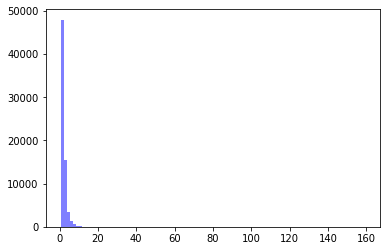

saving..
training_sub_c_model_v5_fe_cv_2.0061_local.csv


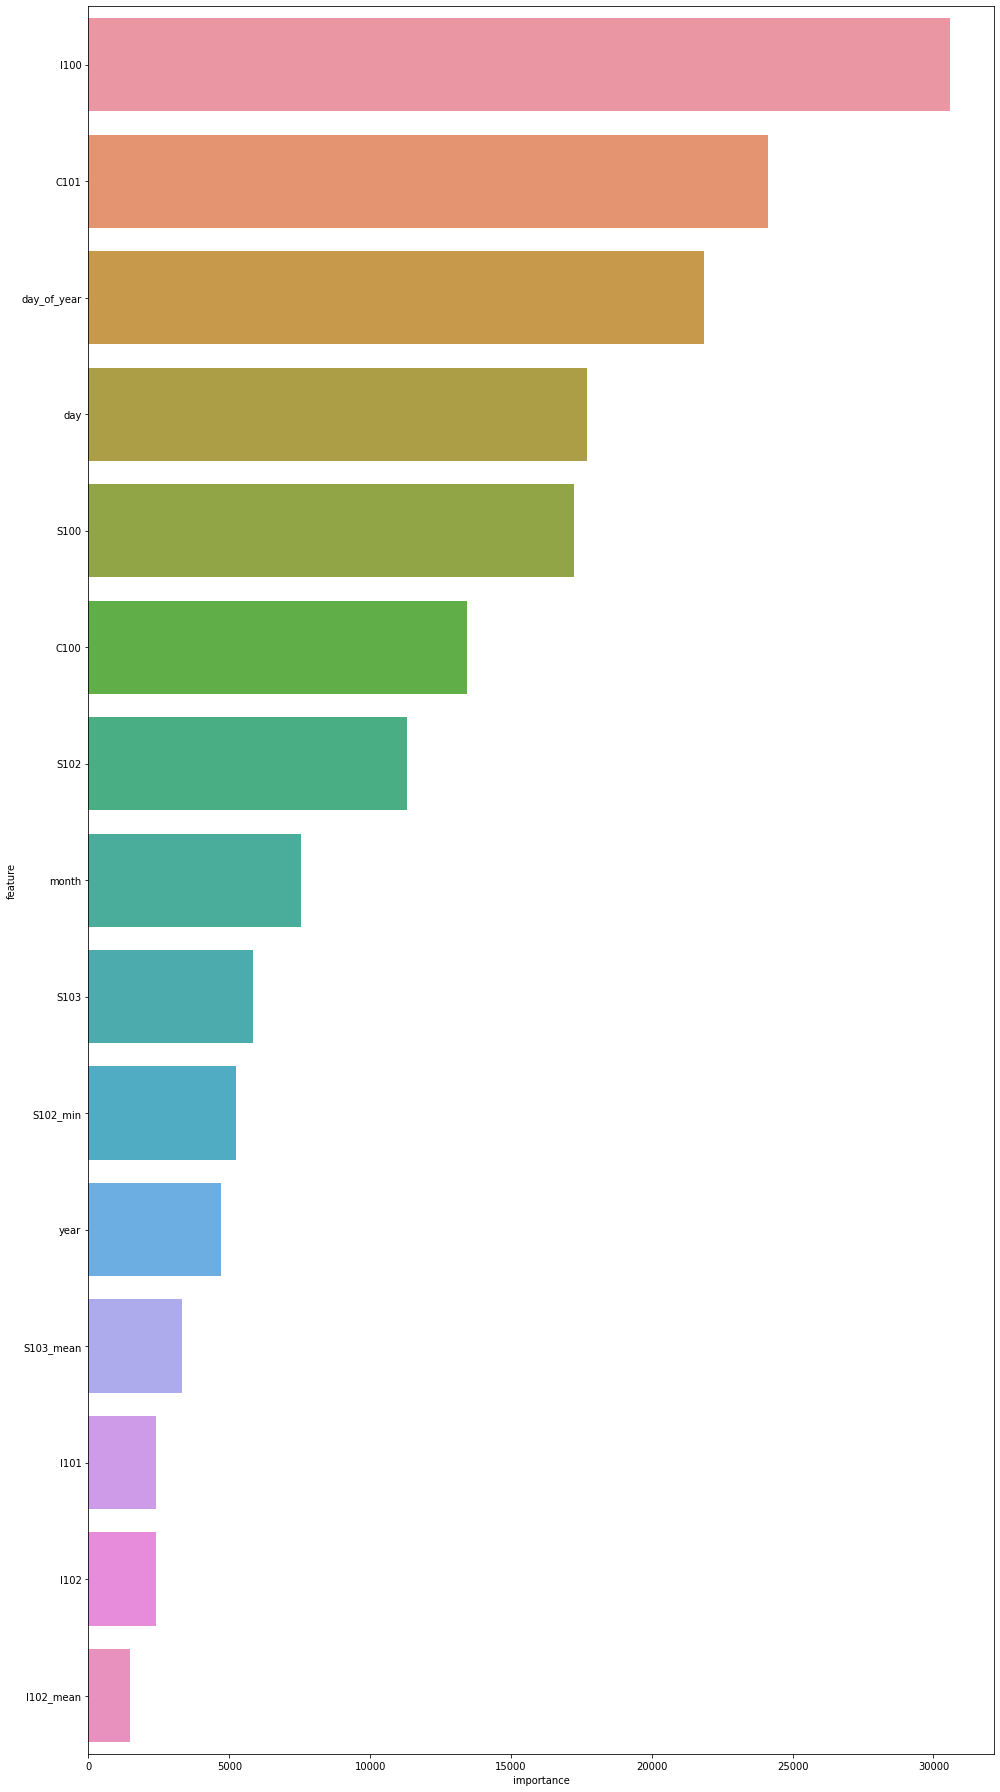

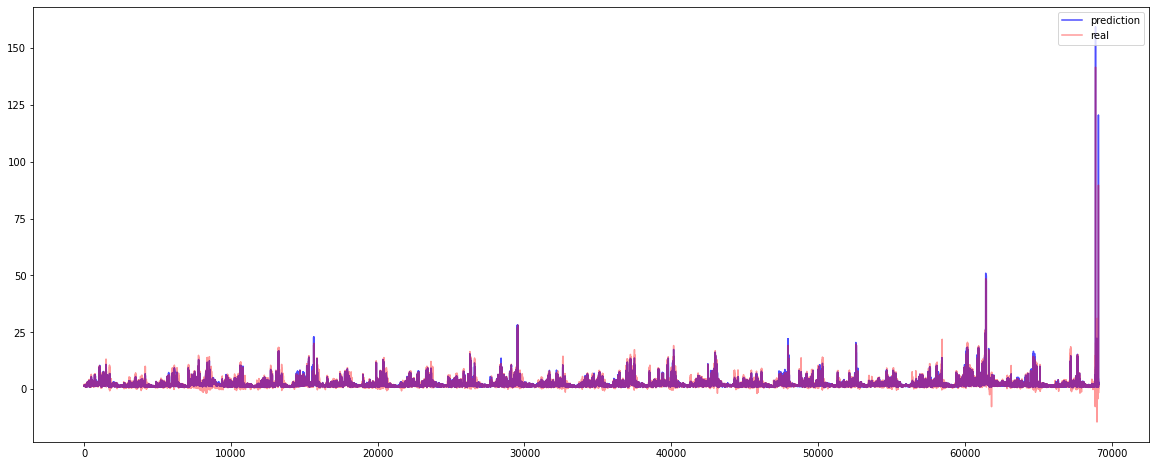

Final score mean_squared_error
Score train: 0.5972515082845902


In [36]:
# predicted value distribution
import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds_fi, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# feature importance
final_importance_fi = feature_importance_df_fi[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance_fi.reset_index(inplace=True)
final_importance_fi

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance_fi)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS,'lgbm_importances.png'))

df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = predictions_submission_fi.mean(axis=1)
df_submission_sample.head()

save = True
if save:
    filename_submission= 'training_sub_'+model_version+'_cv_'+str(np.round(cv_score,4))+'_local.csv'
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',model_version,filename_submission),index=None)
    
###################
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

#######
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)
